In [4]:
from rouge import Rouge
import numpy as np
from gensim.models.keyedvectors import KeyedVectors
from tqdm import tqdm_notebook
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
%matplotlib inline

## 数据预处理

数据处理参考https://github.com/becxer/cnn-dailymail/ ，对源代码做了修改让代码输出txt文件，相应代码在./data/cnn-dailymail中

将标点符号去掉

In [3]:
stop_words = {"-lrb-", "-rrb-", "-"}

In [4]:
data_dir = "./data/cnn-dailymail/finished_files/test.txt"

In [5]:
punctuation = "'!\"#$%&\'()*+,-/:;<=>?@[\\]^_`{|}~'." 

def get_xy_tuple(content, summary):
    x = read_content(content)
    y = read_summary(summary)

    if x != None and y != None:
        return (x, y)
    else:
        return None
    
def read_summary(summary):
    summary = summary.replace("<s>", "")
    summary = summary.replace("</s>", "")
    summary = remove_punctuations(summary)
#     summary = summary.split()
#     words = [word for word in summary if word not in stop_words]
    return summary
    
def read_content(content):
    content = remove_punctuations(content)
#     content = content.split()
#     words = [word for word in content if word not in stop_words]
    return content

def remove_punctuations(doc):
    if isinstance(doc, str):
        return doc.translate(str.maketrans('', '', punctuation))
    elif isinstance(doc, list):
        return [line.translate(str.maketrans('', '', punctuation)) for line in doc]

lines = []
x = []
with open(data_dir) as f:
    for line in f:
        line = line.strip("\n")
        if line.startswith("<s>"):
            y = line
        elif line.endswith("</content>"):
            xy_tuple = get_xy_tuple(x,y)
            x = []
            if xy_tuple != None:
                lines.append(xy_tuple)
        elif line.startswith("<content>"):
            x.append(line[9:])
        else:
            x.append(line)

## 获取句向量

通过word2vec平均或者用tfidf加权平均的方式得到句向量

word2vec模型使用谷歌在GoogleNews上训练的模型，可见https://code.google.com/archive/p/word2vec/
下载地址：https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit

In [ ]:
word2vec = KeyedVectors.load_word2vec_format(
    './data/GoogleNews-vectors-negative300.bin', binary=True, limit=300000)

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

a = ["".join(line[0]) for line in lines]

vectorizer = TfidfVectorizer(min_df=2)
X = vectorizer.fit_transform(a)
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
print('vocab size :', len(tfidf))

vocab size : 57857


### 平均词向量

In [6]:
def sentence2vec(sentences):
    res = []
    for sentence in sentences:
        vec = np.zeros((300,))
        num_word = 0
        for word in sentence.split():
            if word not in stop_words and word in word2vec:
                num_word += 1
                vec += word2vec[word]
        if num_word:
            res.append(vec/num_word)
    return res

### TF-IDF加权

In [7]:
def tfidfVec(sentences, tfidf):
    res = []
    for sentence in sentences:
        vec = np.zeros((300,))
        num_word = 0
        for word in sentence.split():
            if word not in stop_words and word in word2vec and word in tfidf:
                num_word += 1
                vec += word2vec[word] * tfidf[word]
        if num_word:
            res.append(vec/num_word)
    return res

### InferSent

InferSent使用的词嵌入和训练所得的模型参数下载地址如下

Glove：http://nlp.stanford.edu/data/glove.840B.300d.zip 

fastText：https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip 

Glove model：https://dl.fbaipublicfiles.com/infersent/infersent1.pkl 

fastText model：https://dl.fbaipublicfiles.com/infersent/infersent2.pkl 

In [3]:
import numpy as np
import time

import torch
import torch.nn as nn


class InferSent(nn.Module):

    def __init__(self, config):
        super(InferSent, self).__init__()
        self.bsize = config['bsize']
        self.word_emb_dim = config['word_emb_dim']
        self.enc_lstm_dim = config['enc_lstm_dim']
        self.pool_type = config['pool_type']
        self.dpout_model = config['dpout_model']
        self.version = 1 if 'version' not in config else config['version']

        self.enc_lstm = nn.LSTM(self.word_emb_dim, self.enc_lstm_dim, 1,
                                bidirectional=True, dropout=self.dpout_model)

        assert self.version in [1, 2]
        if self.version == 1:
            self.bos = '<s>'
            self.eos = '</s>'
            self.max_pad = True
            self.moses_tok = False
        elif self.version == 2:
            self.bos = '<p>'
            self.eos = '</p>'
            self.max_pad = False
            self.moses_tok = True

    def is_cuda(self):
        # either all weights are on cpu or they are on gpu
        return self.enc_lstm.bias_hh_l0.data.is_cuda

    def forward(self, sent_tuple):
        # sent_len: [max_len, ..., min_len] (bsize)
        # sent: (seqlen x bsize x worddim)
        sent, sent_len = sent_tuple

        # Sort by length (keep idx)
        sent_len_sorted, idx_sort = np.sort(sent_len)[::-1], np.argsort(-sent_len)
        sent_len_sorted = sent_len_sorted.copy()
        idx_unsort = np.argsort(idx_sort)

        idx_sort = torch.from_numpy(idx_sort).cuda() if self.is_cuda() \
            else torch.from_numpy(idx_sort)
        sent = sent.index_select(1, idx_sort)

        # Handling padding in Recurrent Networks
        sent_packed = nn.utils.rnn.pack_padded_sequence(sent, sent_len_sorted)
        sent_output = self.enc_lstm(sent_packed)[0]  # seqlen x batch x 2*nhid
        sent_output = nn.utils.rnn.pad_packed_sequence(sent_output)[0]

        # Un-sort by length
        idx_unsort = torch.from_numpy(idx_unsort).cuda() if self.is_cuda() \
            else torch.from_numpy(idx_unsort)
        sent_output = sent_output.index_select(1, idx_unsort)

        # Pooling
        if self.pool_type == "mean":
            sent_len = torch.FloatTensor(sent_len.copy()).unsqueeze(1).cuda()
            emb = torch.sum(sent_output, 0).squeeze(0)
            emb = emb / sent_len.expand_as(emb)
        elif self.pool_type == "max":
            if not self.max_pad:
                sent_output[sent_output == 0] = -1e9
            emb = torch.max(sent_output, 0)[0]
            if emb.ndimension() == 3:
                emb = emb.squeeze(0)
                assert emb.ndimension() == 2

        return emb

    def set_w2v_path(self, w2v_path):
        self.w2v_path = w2v_path

    def get_word_dict(self, sentences, tokenize=True):
        # create vocab of words
        word_dict = {}
        sentences = [s.split() if not tokenize else self.tokenize(s) for s in sentences]
        for sent in sentences:
            for word in sent:
                if word not in word_dict:
                    word_dict[word] = ''
        word_dict[self.bos] = ''
        word_dict[self.eos] = ''
        return word_dict

    def get_w2v(self, word_dict):
        assert hasattr(self, 'w2v_path'), 'w2v path not set'
        # create word_vec with w2v vectors
        word_vec = {}
        with open(self.w2v_path, encoding='utf-8') as f:
            for line in f:
                word, vec = line.split(' ', 1)
                if word in word_dict:
                    word_vec[word] = np.fromstring(vec, sep=' ')
        print('Found %s(/%s) words with w2v vectors' % (len(word_vec), len(word_dict)))
        return word_vec

    def get_w2v_k(self, K):
        assert hasattr(self, 'w2v_path'), 'w2v path not set'
        # create word_vec with k first w2v vectors
        k = 0
        word_vec = {}
        with open(self.w2v_path, encoding='utf-8') as f:
            for line in f:
                word, vec = line.split(' ', 1)
                if k <= K:
                    word_vec[word] = np.fromstring(vec, sep=' ')
                    k += 1
                if k > K:
                    if word in [self.bos, self.eos]:
                        word_vec[word] = np.fromstring(vec, sep=' ')

                if k > K and all([w in word_vec for w in [self.bos, self.eos]]):
                    break
        return word_vec

    def build_vocab(self, sentences, tokenize=True):
        assert hasattr(self, 'w2v_path'), 'w2v path not set'
        word_dict = self.get_word_dict(sentences, tokenize)
        self.word_vec = self.get_w2v(word_dict)
        print('Vocab size : %s' % (len(self.word_vec)))

    # build w2v vocab with k most frequent words
    def build_vocab_k_words(self, K):
        assert hasattr(self, 'w2v_path'), 'w2v path not set'
        self.word_vec = self.get_w2v_k(K)
        print('Vocab size : %s' % (K))

    def update_vocab(self, sentences, tokenize=True):
        assert hasattr(self, 'w2v_path'), 'warning : w2v path not set'
        assert hasattr(self, 'word_vec'), 'build_vocab before updating it'
        word_dict = self.get_word_dict(sentences, tokenize)

        # keep only new words
        for word in self.word_vec:
            if word in word_dict:
                del word_dict[word]

        # udpate vocabulary
        if word_dict:
            new_word_vec = self.get_w2v(word_dict)
            self.word_vec.update(new_word_vec)
        else:
            new_word_vec = []
        print('New vocab size : %s (added %s words)'% (len(self.word_vec), len(new_word_vec)))

    def get_batch(self, batch):
        # sent in batch in decreasing order of lengths
        # batch: (bsize, max_len, word_dim)
        embed = np.zeros((len(batch[0]), len(batch), self.word_emb_dim))

        for i in range(len(batch)):
            for j in range(len(batch[i])):
                embed[j, i, :] = self.word_vec[batch[i][j]]

        return torch.FloatTensor(embed)

    def tokenize(self, s):
        from nltk.tokenize import word_tokenize
        if self.moses_tok:
            s = ' '.join(word_tokenize(s))
            s = s.replace(" n't ", "n 't ")  # HACK to get ~MOSES tokenization
            return s.split()
        else:
            return word_tokenize(s)

    def prepare_samples(self, sentences, bsize, tokenize, verbose):
        sentences = [[self.bos] + s.split() + [self.eos] if not tokenize else
                     [self.bos] + self.tokenize(s) + [self.eos] for s in sentences]
        n_w = np.sum([len(x) for x in sentences])

        # filters words without w2v vectors
        for i in range(len(sentences)):
            s_f = [word for word in sentences[i] if word in self.word_vec]
            if not s_f:
                import warnings
                warnings.warn('No words in "%s" (idx=%s) have w2v vectors. \
                               Replacing by "</s>"..' % (sentences[i], i))
                s_f = [self.eos]
            sentences[i] = s_f

        lengths = np.array([len(s) for s in sentences])
        n_wk = np.sum(lengths)
        if verbose:
            print('Nb words kept : %s/%s (%.1f%s)' % (
                        n_wk, n_w, 100.0 * n_wk / n_w, '%'))

        # sort by decreasing length
        lengths, idx_sort = np.sort(lengths)[::-1], np.argsort(-lengths)
        sentences = np.array(sentences)[idx_sort]

        return sentences, lengths, idx_sort

    def encode(self, sentences, bsize=64, tokenize=True, verbose=False):
        tic = time.time()
        sentences, lengths, idx_sort = self.prepare_samples(
                        sentences, bsize, tokenize, verbose)

        embeddings = []
        for stidx in range(0, len(sentences), bsize):
            batch = self.get_batch(sentences[stidx:stidx + bsize])
            if self.is_cuda():
                batch = batch.cuda()
            with torch.no_grad():
                batch = self.forward((batch, lengths[stidx:stidx + bsize])).data.cpu().numpy()
            embeddings.append(batch)
        embeddings = np.vstack(embeddings)

        # unsort
        idx_unsort = np.argsort(idx_sort)
        embeddings = embeddings[idx_unsort]

        if verbose:
            print('Speed : %.1f sentences/s (%s mode, bsize=%s)' % (
                    len(embeddings)/(time.time()-tic),
                    'gpu' if self.is_cuda() else 'cpu', bsize))
        return embeddings

    def visualize(self, sent, tokenize=True):

        sent = sent.split() if not tokenize else self.tokenize(sent)
        sent = [[self.bos] + [word for word in sent if word in self.word_vec] + [self.eos]]

        if ' '.join(sent[0]) == '%s %s' % (self.bos, self.eos):
            import warnings
            warnings.warn('No words in "%s" have w2v vectors. Replacing \
                           by "%s %s"..' % (sent, self.bos, self.eos))
        batch = self.get_batch(sent)

        if self.is_cuda():
            batch = batch.cuda()
        output = self.enc_lstm(batch)[0]
        output, idxs = torch.max(output, 0)
        # output, idxs = output.squeeze(), idxs.squeeze()
        idxs = idxs.data.cpu().numpy()
        argmaxs = [np.sum((idxs == k)) for k in range(len(sent[0]))]

        # visualize model
        import matplotlib.pyplot as plt
        x = range(len(sent[0]))
        y = [100.0 * n / np.sum(argmaxs) for n in argmaxs]
        plt.xticks(x, sent[0], rotation=45)
        plt.bar(x, y)
        plt.ylabel('%')
        plt.title('Visualisation of words importance')
        plt.show()

        return output, idxs

In [ ]:
model_version = 1
print("model_version:",model_version)
MODEL_PATH = "encoder/infersent%s.pkl" % model_version
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': model_version}
model = InferSent(params_model)
model.load_state_dict(torch.load(MODEL_PATH))

# Keep it on CPU or put it on GPU
use_cuda = True
model = model.cuda() if use_cuda else model

# If infersent1 -> use GloVe embeddings. If infersent2 -> use InferSent embeddings.
W2V_PATH = '../data/glove.840B.300d.txt' if model_version == 1 else '../data/fastText/crawl-300d-2M.vec'
model.set_w2v_path(W2V_PATH)

# Load embeddings of K most frequent words
model.build_vocab_k_words(K=500000)

## 获取摘要

### 聚类

In [ ]:
hypothesis = []
reference = []
n_clusters = 3

for x,y in tqdm_notebook(lines):
    try:
        sentVec = sentence2vec(x)
#         sentVec = tfidfVec(x, tfidf)
#         sentVec = model.encode(x)
        kmeans = KMeans(n_clusters=n_clusters)
        kmeans = kmeans.fit(sentVec)
        avg = []
        for j in range(n_clusters):
            idx = np.where(kmeans.labels_ == j)[0]
            avg.append(np.mean(idx))
        closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, sentVec)
        ordering = sorted(range(n_clusters), key=lambda k: avg[k])
        summary = ' '.join([x[closest[idx]] for idx in ordering])

        reference.append(y)
        hypothesis.append(summary)
    except:
        print("error:", x, y)

rouge = Rouge()
scores = rouge.get_scores(hypothesis, reference, avg=True)
scores

error: ['lrb cnn rrb once hillary clinton s official announcement went online  social media responded in a big way  with terms like  hillary clinton    hillary2016   and yes  even  whyimnotvotingforhillary  trending ', 'certainly  you could nt go far on twitter lrb even before clinton tweeted her announcement rrb  without an opinion or thought on her new campaign lrb there were over 3 million views of her announcment tweets in one hour  and 750000 facebook video views so far by sunday evening rrb ']  response across social media led to multiple trending topics for hillary clinton s presidential announcement    some responded to her video and her new campaign logo  
error: ['the masters 2015 is almost here  to help get you in the mood for the first major of the year  rory mcilroy  ian poulter  graeme mcdowell and justin rose  plus past masters champions nick faldo and charl schwartzel  give the lowdown on every hole at the worldfamous augusta national golf club ']  the 79th masters tour

### 可视化聚类结果

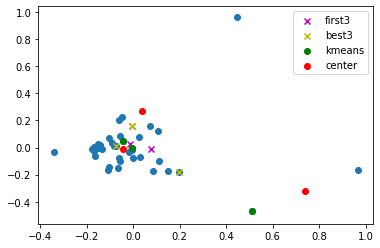

In [69]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import itertools

x = lines[0][0]
y = lines[0][1]

rouge = Rouge()
c = list(itertools.combinations(x,3))
max_scores = 0
for sents in tqdm_notebook(c):
    hypothesis = "".join(sents)
    score = rouge.get_scores(hypothesis, y)[0]
    score = (score["rouge-1"]["f"] + score["rouge-2"]["f"] + score["rouge-l"]["f"]) / 3
    if score > max_scores:
        max_scores = score
        best_c = sent

sentVec = sentence2vec(x)
pca = PCA(n_components=2)
pca.fit(sentVec)
a = pca.transform(sentVec)
plt.scatter(a[:3,0], a[:3,1], marker = 'x', color = 'm', label='first3')
plt.scatter(a[3:,0], a[3:,1])

plt.scatter(a[best3_idx[0],0], a[best3_idx[0],1], marker='x', color = 'y')
for i in best3_idx:
    plt.scatter(a[i,0], a[i,1], marker='x', color = 'y', label='best3')

kmeans = KMeans(n_clusters=3,random_state=42)
kmeans = kmeans.fit(sentVec)
centers = pca.transform(kmeans.cluster_centers_)
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, sentVec)
for c in closest:
    plt.scatter(a[c,0], a[c,1], color='g', label="kmeans")
plt.scatter(centers[:,0], centers[:,1], marker = "o", color = 'r', label='center')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

### Textrank

In [ ]:
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
rouge = Rouge()

hypothesis = []
reference = []
sn = 3

for x,y in tqdm_notebook(lines):
    try:
        sentence_vectors = sentence2vec(x)
#         sentence_vectors = tfidfVec(x, tfidf)
#         sentence_vectors = model.encode(x)
        sim_mat = np.zeros([len(x), len(x)])
        for i in range(len(x)):
            for j in range(len(x)):
                if i != j:
                    sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,300), sentence_vectors[j].reshape(1,300))[0,0]
        nx_graph = nx.from_numpy_array(sim_mat)
        scores = nx.pagerank(nx_graph)
        rank_scores = sorted(range(len(scores)), key=lambda k: scores.get(k), reverse=True)
        ordering = sorted(range(sn), key=lambda k: rank_scores[k])

        hypothesis.append(''.join([x[rank_scores[idx]] for idx in ordering]))
        reference.append(y)
    except:
        print("error:",x,y)
        continue

    
scores = rouge.get_scores(hypothesis, reference, avg=True)
print(scores)

### MMR

In [ ]:
import operator

def calculateSimilarity(sentence,doc):
    cos_sim = 0.0
    for vec in doc:
        try:
            cos_sim += np.inner(sentence, vec) / (np.linalg.norm(sentence) * np.linalg.norm(vec))
        except:
            continue
    return cos_sim / len(doc)
    
alpha = 0.5
print("alpha:", alpha)
for x,y in tqdm(lines):
    try:
        doc = ["".join(x)]
#         x_vec = sentence2vec(x)
#         doc_vec = sentence2vec(doc)
        
#         x_vec = tfidfVec(x, tfidf)
#         doc_vec =  tfidfVec(doc, tfidf)
        x_vec = model.encode(x)
        doc_vec =  model.encode(doc)

        scores = []
        for vec in x_vec:
            scores.append(calculateSimilarity(vec, doc_vec))

        max_index = scores.index(max(scores))

        n = 3
        summarySet = []

        while n > 0:
            mmr = {}
            for index in range(len(x)):
                sentence = x[index]
                vec = x_vec[index]
                if not sentence in summarySet:
                    mmr[sentence] = alpha * scores[index] - (1 - alpha) * calculateSimilarity(vec, doc_vec)
            selected = max(mmr.items(), key=operator.itemgetter(1))[0]
            summarySet.append(selected)
            n -= 1
        hypothesis.append("".join(summarySet))
        reference.append(y)
    except Exception as e:
        print("error:", x, y)
        print(e)

rouge = Rouge()
scores = rouge.get_scores(hypothesis, reference, avg=True)
print(scores)

## Baseline

### 直接取前三句

In [14]:
rouge = Rouge()

hypothesis = []
reference = []

for x,y in tqdm_notebook(lines):
    first3sentence = x[:3]
    if len("".join(first3sentence)) < 10:
        continue
    hypothesis.append(''.join(first3sentence))
    reference.append(y)

    
scores = rouge.get_scores(hypothesis, reference, avg=True)
scores

{'rouge-1': {'f': 0.4061975886142278,
  'p': 0.3492116467886355,
  'r': 0.5203605937110696},
 'rouge-2': {'f': 0.17052685675218657,
  'p': 0.14371171733197152,
  'r': 0.23018089464057517},
 'rouge-l': {'f': 0.24860135480039966,
  'p': 0.23403361999142586,
  'r': 0.35053142615024646}}

### 随机取三句

In [17]:
import itertools
import random

rouge = Rouge()
hypothesis = []
reference = []

for x,y in tqdm_notebook(lines):
    c = list(itertools.combinations(x,3))
    try:
        h = random.choice(c)
    except:
        continue
    if len("".join(h)) < 10:
        continue
    hypothesis.append("".join(h))
    reference.append(y)


scores = rouge.get_scores(hypothesis, reference, avg=True)
scores

{'rouge-1': {'f': 0.2890532563335098,
  'p': 0.2583631099718259,
  'r': 0.3578374087947165},
 'rouge-2': {'f': 0.08516945177073726,
  'p': 0.07553395151286886,
  'r': 0.1098537965184604},
 'rouge-l': {'f': 0.173403734703439,
  'p': 0.1686255879027422,
  'r': 0.23433493594892973}}

### 理论最优三句

In [ ]:
rouge = Rouge()
hypothesis = []
reference = []

for x,y in tqdm_notebook(lines):
    try:
        max_scores = 0
        c = list(itertools.combinations(x,3))
        for a in c:
            scores = rouge.get_scores("".join(a), y)[0]
            avg_scores = (scores["rouge-1"]["f"] +  scores["rouge-1"]["f"] + scores["rouge-1"]["f"]) / 3
            if avg_scores > max_scores:
                max_scores = avg_scores
                best_sents = "".join(a)

        hypothesis.append(best_sents)
        reference.append(y)
    except:
        print("error:",x,y)


scores = rouge.get_scores(hypothesis, reference, avg=True)
print(scores)